- https://medium.com/@YasinShafiei/deep-convolution-gan-on-fashion-mnist-using-pytorch-e99619940997
- https://github.com/YasinShafiei/FashionMnist_DCGAN

In [1]:
import torch
import torchvision

In [2]:
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(111)

In [5]:
torch.__version__

'2.4.0+cu118'

In [6]:
device = None

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
device

device(type='cuda')

## models

In [8]:
class Generator(nn.Module):
    
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()
        """
        In this function the generator model will be defined with all of it layers.
        The generator model uses 4 ConvTranspose blocks. Each block containes 
        a ConvTranspose2d, BatchNorm2d and ReLU activation.
        """
        # define the model
        self.model = nn.Sequential(
            # Transpose block 1
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            # Transpose block 2
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            # Transpose block 3
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 4
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Last transpose block (different)
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()
        """
        This function will define the Discriminator model with all the layers needed.
        The model has 5 Conv blocks. The blocks have Conv2d, BatchNorm and LeakyReLU activation.
        """
        # define the model
        self.model = nn.Sequential(
            # define the first Conv block
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Conv block 2 
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),

            # Conv block 3
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            # Conv block 4
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            # Conv block 5 (different)
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## parameters

In [10]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
IMAGE_SIZE = 64
EPOCHS = 300

In [11]:
image_channels = 1
noise_channels = 256

In [12]:
generator_features = 64
discriminator_features = 64

## dataset

In [13]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [14]:
dataset = FashionMNIST(root="data", train=True, transform=data_transforms, download=True)

In [15]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## models

In [16]:
generator = Generator(noise_channels, image_channels, generator_features).to(device)

In [17]:
discriminator = Discriminator(image_channels, discriminator_features).to(device)

## optimizers

In [18]:
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [19]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## loss

In [20]:
loss = nn.BCELoss()

## train

In [21]:
generator.train()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Tanh()
  )
)

In [22]:
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [23]:
# define labels for fake images and real images for the discriminator
fake_label = 0
real_label = 1

In [24]:
# define a fixed noise 
fixed_noise = torch.randn(64, noise_channels, 1, 1).to(device)

In [25]:
# make the writers for tensorboard
tb_writer = SummaryWriter('tensorboard/fashion')

In [26]:
# define a step
step = 0

In [27]:
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(dataloader):
        # get the batch size 
        batch_size = data.shape[0]

        # real data
        real_samples = data.to(device)
        real_label = (torch.ones(batch_size) * 0.9).to(device)

        # initialize the discriminator
        discriminator.zero_grad()

        # train the discriminator model on real data
        real_output = discriminator(real_samples).reshape(-1)
        real_discriminator_loss = loss(real_output, real_label)

        # fake data
        fake_vectors = torch.randn(batch_size, noise_channels, 1, 1).to(device)
        fake_labels = (torch.ones(batch_size) * 0.1).to(device)
        fake_samples = generator(fake_vectors)

        # train the discriminator model on fake (generated) data
        fake_output = discriminator(fake_samples.detach()).reshape(-1)
        fake_discriminator_loss = loss(fake_output, fake_labels)

        # calculate the final discriminator loss
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss

        # apply the optimizer and gradient to the discriminator
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # initialize the generator
        generator.zero_grad()

        # generated data
        generated_samples = fake_samples
        generated_labels = (torch.ones(batch_size) * 1.0).to(device)

        # train the generator model
        generated_output = discriminator(generated_samples).reshape(-1)
        generator_loss = loss(generated_output, generated_labels)
        
        # apply the optimizer and gradient to the generator
        generator_loss.backward()
        generator_optimizer.step()

        # print losses in console and tensorboard
        if batch_idx % 50 == 0:
            step += 1

            # print everything
            print(f"epoch: {epoch:03d}, step: {step:06d}, D: {discriminator_loss:.4f}, G: {generator_loss:.4f}")

            # test the model
            with torch.no_grad():
                # generate fake images
                fake_images = generator(fixed_noise)

            # report fake images 
            img_grid_fake = torchvision.utils.make_grid(fake_images[:40], normalize=True)
            tb_writer.add_image("generated", img_grid_fake, global_step=step)

            # report real images 
            img_grid_real = torchvision.utils.make_grid(data[:40], normalize=True)
            tb_writer.add_image("real", img_grid_real, global_step=step)

            # report losses
            loss_dict = {'generator': generator_loss, 'discriminator': discriminator_loss} 
            tb_writer.add_scalars('loss', loss_dict, global_step=step)

            # flush tensorboard
            tb_writer.flush()

epoch: 000, step: 000001, D: 1.3850, G: 6.6193
epoch: 000, step: 000002, D: 0.6652, G: 2.7151
epoch: 000, step: 000003, D: 0.6892, G: 3.3023
epoch: 000, step: 000004, D: 0.7449, G: 3.6177
epoch: 000, step: 000005, D: 1.2438, G: 1.6866
epoch: 001, step: 000006, D: 1.2570, G: 1.0308
epoch: 001, step: 000007, D: 1.5555, G: 1.1095
epoch: 001, step: 000008, D: 1.1739, G: 1.2860
epoch: 001, step: 000009, D: 1.1964, G: 1.7981
epoch: 001, step: 000010, D: 1.1050, G: 1.0399
epoch: 002, step: 000011, D: 1.2813, G: 1.2811
epoch: 002, step: 000012, D: 1.6203, G: 0.5164
epoch: 002, step: 000013, D: 0.7821, G: 1.6554
epoch: 002, step: 000014, D: 1.2955, G: 1.1099
epoch: 002, step: 000015, D: 1.4163, G: 1.0320
epoch: 003, step: 000016, D: 1.2486, G: 2.1415
epoch: 003, step: 000017, D: 1.2029, G: 0.9058
epoch: 003, step: 000018, D: 1.2641, G: 2.1738
epoch: 003, step: 000019, D: 0.9098, G: 1.5868
epoch: 003, step: 000020, D: 0.9953, G: 2.6097
epoch: 004, step: 000021, D: 0.9683, G: 1.1268
epoch: 004, s

In [28]:
tb_writer.close()

## result

In [29]:
with torch.no_grad():
    # generate fake images
    fake_images = generator(fixed_noise)

In [30]:
# report fake images 
img_grid_fake = torchvision.utils.make_grid(fake_images[:40], normalize=True)

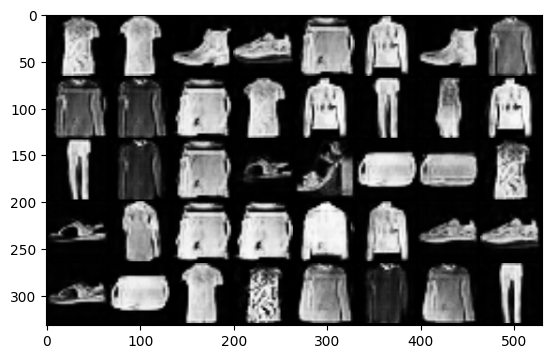

In [31]:
plt.imshow(img_grid_fake.cpu().permute(1, 2, 0))

## tensorboard

In [32]:
%load_ext tensorboard

In [33]:
%tensorboard --logdir tensorboard/fashion